In [1]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.spatial import distance
import pathlib
import os
from sklearn.decomposition import PCA
import json
import random
from random import sample

random.seed(30)

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
# Import the guide-level profiles
df_guide = pd.read_csv("outputs/20240202_6W_CP498_SABER_Pilot_HeLa_guide_normalized_merged_feature_select_median_ALLWELLS_cp.csv.gz")
# Subset the nontargeting guide profiles 
df_nontargeting = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting'")

# Load hits from the hit calling process
whole_cell_hits = pd.read_csv('outputs/HeLa_CP_plate_level_median_per_feat_sig_genes_5_FDR_whole_cell_hits.csv')
comp_spec_hits = pd.read_csv('outputs/HeLa_CP_plate_level_median_per_feat_sig_genes_5_FDR_compartment_specific_hits.csv')
all_hits = pd.concat([whole_cell_hits,comp_spec_hits])
hit_list = list(comp_spec_hits.Gene) + list(whole_cell_hits.Gene)
whole_cell_hit_list = list(whole_cell_hits.Gene)
comp_spec_hit_list = list(comp_spec_hits.Gene)

# list non hit genes
all_genes_list = list(df_guide.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
all_genes_list.remove("nontargeting")
non_hit_list = [gene for gene in all_genes_list if gene not in hit_list]
groups = ['Whole cell hit','Compartment hit','Non hit','All gene']
groups_dic = {'Whole cell hit':whole_cell_hit_list,'Compartment hit':comp_spec_hit_list,'Non hit':non_hit_list,'All gene':all_genes_list}
print("All genes:",len(all_genes_list),"non-hit genes",len(non_hit_list),'Whole cell hits',len(whole_cell_hit_list),'Compartment hits',len(comp_spec_hit_list))

All genes: 590 non-hit genes 189 Whole cell hits 379 Compartment hits 22


In [4]:
df_temp = df_guide.copy(deep=True)
features = list(df_guide.columns)
gene_list = list(df_temp.Metadata_Foci_Barcode_MatchedTo_GeneCode)
df_temp = df_temp.drop('Metadata_Foci_Barcode_MatchedTo_GeneCode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_Barcode')
df_temp = df_temp.reset_index()
df_temp["Metadata_Foci_Barcode_MatchedTo_GeneCode"] = gene_list
df_temp = df_temp[features]
df_temp

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,Cells_AreaShape_CentralMoment_2_1,...,Nuclei_Texture_InfoMeas1_Mito_5_01_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_WGA_10_00_256,Nuclei_Texture_InfoMeas1_WGA_5_00_256,Nuclei_Texture_InfoMeas1_WGA_5_02_256,Nuclei_Texture_InfoMeas2_DAPI_Painting_10_03_256,Nuclei_Texture_InfoMeas2_Mito_5_02_256,Nuclei_Texture_InfoMeas2_Phalloidin_5_00_256,Nuclei_Texture_SumAverage_DAPI_Painting_10_03_256,Nuclei_Texture_SumVariance_Mito_10_03_256
0,AARS2,AAAGGCGGCCCTCACGGCCG,-0.049695,-0.007310,0.068068,0.282360,-0.716255,0.005817,0.218232,-0.154402,...,0.327775,0.296771,0.487940,0.305170,0.191921,0.154430,-0.252812,-0.493225,0.296880,-0.279502
1,AARS2,AGCAAACTGGGGTCGCCGCG,-0.056370,0.034850,-0.129720,0.102712,-0.227415,0.196801,0.005880,-0.064720,...,-0.125585,-0.222343,-0.267363,-0.014090,-0.084492,0.081421,0.078580,0.115098,-0.156265,-0.170241
2,AARS2,CCAACTTCTACGCAGAACAG,-0.160030,-0.091385,0.148568,-0.216035,0.034805,0.163045,0.066160,0.356585,...,-0.402410,-0.458070,-0.447815,-0.317605,-0.398200,0.132896,0.480540,0.317265,-0.341360,0.114366
3,AARS2,GCTGAGCCAGTTCAGAAGCA,0.286901,0.142030,-0.313969,-0.053498,0.153567,-0.259566,0.012046,-0.067856,...,0.165980,-0.044400,-0.000590,0.041017,0.098723,0.022136,-0.142982,-0.108239,-0.352795,-0.215195
4,AARSD1,ACCTCCGCTCCCAATCTACC,-0.135745,-0.062917,-0.331497,0.277325,0.218805,0.064993,-0.232255,-0.474220,...,0.639800,0.435405,0.689870,0.815490,0.522225,-0.641835,-0.834870,-0.789625,-0.769190,-0.571055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,nontargeting,TAAGATCCGCGGGTGGCAAC,-0.471880,0.069689,0.247578,-0.353750,-0.685932,-0.330715,-0.401865,0.184790,...,0.359865,0.634615,0.465790,0.498780,0.270355,0.246790,-0.308400,-0.426650,0.200284,-0.234015
2396,nontargeting,TCCCGGTTGGTGAACGATAC,0.023480,-0.463288,0.601885,0.030910,0.374675,-0.112565,0.301557,-0.650605,...,0.656175,0.597540,0.525310,0.580275,0.617890,0.059865,-0.553425,-0.592625,-0.313280,-0.296670
2397,nontargeting,TGCCGTGAAAAGACGCTGCG,-0.513425,-0.240830,0.340108,0.132513,-0.012648,0.194555,0.042534,-0.164266,...,0.235540,0.400525,0.278735,0.500875,0.429855,-0.129978,-0.430115,-0.451555,-0.036847,-0.352740
2398,nontargeting,TGGCCACGAATTCCGCCGCC,-0.011335,-0.114445,0.042562,-0.008606,0.443205,0.138462,0.008197,0.031328,...,0.500430,0.425680,0.443780,0.492115,0.476090,0.398430,-0.498765,-0.494330,0.441350,-0.380610


In [5]:
df_temp = df_guide.drop('Metadata_Foci_Barcode_MatchedTo_GeneCode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_Barcode')
# Perform principal component analysis on hit list
pca = PCA()
pca.fit(df_temp)
x = list(pca.explained_variance_ratio_)
# Find principal component that represents 90% variation
PCA_lookup = {}
for i in range(len(x)):
    distance = abs(.9-sum(x[:i+1]))
    PCA_lookup[distance] = i 
component = PCA_lookup[min(PCA_lookup.keys())]+1
print (f'Principal component representing closest to 90% variation is {component}')
# Perform principal component analysis and select components representing 90% of variation in data
pca = PCA(n_components=component)
df_guide_pca = pd.DataFrame(pca.fit_transform(df_temp),index=df_temp.index)
df_guide_pca.head()

Principal component representing closest to 90% variation is 102


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
Metadata_Foci_Barcode_MatchedTo_Barcode,,,,,,,,,,,,,,,,,,,,,
AAAGGCGGCCCTCACGGCCG,0.490518,3.686846,-2.171395,-1.993583,-0.866748,-1.599464,0.480717,-0.035573,0.265106,0.184344,...,-0.052781,0.074761,0.056967,-0.319477,0.360751,-0.868344,-0.232003,0.325248,0.216114,0.368545
AGCAAACTGGGGTCGCCGCG,-0.595151,0.286398,-1.600191,-0.321986,-0.368362,1.424164,1.720628,1.428887,-1.090678,-0.981120,...,0.020703,0.075026,-0.289033,0.190005,-0.078751,-0.131611,0.226626,0.378074,0.017305,-0.260719
CCAACTTCTACGCAGAACAG,0.963539,2.582813,-0.102827,0.520521,-0.945019,0.413353,2.533179,1.987972,-1.508222,-1.348158,...,-0.025482,0.099207,-0.159473,0.104487,0.333068,0.007619,0.446023,0.085888,-0.007395,-0.321562
GCTGAGCCAGTTCAGAAGCA,0.259027,2.793519,-3.492034,1.862051,-1.909145,-0.269427,2.377853,1.795668,-0.867346,-0.130631,...,0.186559,-0.102557,0.093525,0.030158,0.200970,0.329199,0.118278,-0.369117,-0.000802,-0.621501
ACCTCCGCTCCCAATCTACC,-8.208768,-5.449111,-2.653009,-1.016760,-2.355556,3.232853,-1.967302,-0.415284,-0.682737,2.383136,...,-0.064728,0.703052,0.216421,0.034086,-0.437883,-0.522078,-0.034942,-0.379240,0.597035,0.253819


In [6]:
df_guide_pca_updated = df_guide_pca.reset_index()
pca_feat_list = list(df_guide_pca_updated.columns)
feat_list = ['Metadata_Foci_Barcode_MatchedTo_GeneCode']
feat_list.extend(pca_feat_list)
df_guide_pca_updated["Metadata_Foci_Barcode_MatchedTo_GeneCode"] = gene_list
df_guide_pca_updated = df_guide_pca_updated[feat_list]
df_guide_pca_updated

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,0,1,2,3,4,5,6,7,...,92,93,94,95,96,97,98,99,100,101
0,AARS2,AAAGGCGGCCCTCACGGCCG,0.490518,3.686846,-2.171395,-1.993583,-0.866748,-1.599464,0.480717,-0.035573,...,-0.052781,0.074761,0.056967,-0.319477,0.360751,-0.868344,-0.232003,0.325248,0.216114,0.368545
1,AARS2,AGCAAACTGGGGTCGCCGCG,-0.595151,0.286398,-1.600191,-0.321986,-0.368362,1.424164,1.720628,1.428887,...,0.020703,0.075026,-0.289033,0.190005,-0.078751,-0.131611,0.226626,0.378074,0.017305,-0.260719
2,AARS2,CCAACTTCTACGCAGAACAG,0.963539,2.582813,-0.102827,0.520521,-0.945019,0.413353,2.533179,1.987972,...,-0.025482,0.099207,-0.159473,0.104487,0.333068,0.007619,0.446023,0.085888,-0.007395,-0.321562
3,AARS2,GCTGAGCCAGTTCAGAAGCA,0.259027,2.793519,-3.492034,1.862051,-1.909145,-0.269427,2.377853,1.795668,...,0.186559,-0.102557,0.093525,0.030158,0.200970,0.329199,0.118278,-0.369117,-0.000802,-0.621501
4,AARSD1,ACCTCCGCTCCCAATCTACC,-8.208768,-5.449111,-2.653009,-1.016760,-2.355556,3.232853,-1.967302,-0.415284,...,-0.064728,0.703052,0.216421,0.034086,-0.437883,-0.522078,-0.034942,-0.379240,0.597035,0.253819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,nontargeting,TAAGATCCGCGGGTGGCAAC,-3.437158,-1.917380,-1.509893,-6.304269,1.405276,1.323337,-2.085760,0.410991,...,-0.505103,0.089538,0.235308,0.188522,0.301384,0.064622,0.422433,0.215962,0.280711,-0.391490
2396,nontargeting,TCCCGGTTGGTGAACGATAC,-3.430271,-2.732776,-4.302808,-6.083132,-1.559545,0.767723,2.057993,2.095852,...,0.482804,-0.187836,-0.011980,-0.132470,0.082797,0.386633,-0.467854,0.176135,0.161875,-0.124496
2397,nontargeting,TGCCGTGAAAAGACGCTGCG,-4.795058,1.198451,-2.267250,-1.555450,-0.321734,-1.636284,0.330087,0.992567,...,-0.140328,-0.106118,0.145622,-0.261022,-0.395456,-0.135057,0.003213,-0.211553,-0.325963,-0.145864
2398,nontargeting,TGGCCACGAATTCCGCCGCC,0.771068,6.087222,-3.422265,-2.934733,0.422449,-2.446637,0.737433,0.045173,...,0.441032,-0.008055,0.216056,-0.104739,0.028815,-0.036761,-0.104876,-0.101775,0.021543,0.025211


In [7]:
def calculate_mean_similarity(cosine_array):
    total_sum = 0
    for i in range(4):
        similarities = cosine_array[i]
        target_sum = 0
        for j in range(4):
            target_sum += similarities[j]  
        target_mean = ((target_sum-1)/3)
        total_sum += target_mean

    total_mean = total_sum / 4
    return total_mean

hit_guide_sim_list =[]
for i in range(len(whole_cell_hit_list)):
    df_temp = df_guide_pca_updated.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == @whole_cell_hit_list[@i]")
    df_temp = df_temp.drop(['Metadata_Foci_Barcode_MatchedTo_Barcode'],axis=1)
    df_temp = df_temp.set_index("Metadata_Foci_Barcode_MatchedTo_GeneCode")
    cosine_array = cosine_similarity(df_temp)
    hit_guide_sim = calculate_mean_similarity(cosine_array)
    hit_guide_sim_list.append(hit_guide_sim)
average_cosine_distance = sum(hit_guide_sim_list)/len(hit_guide_sim_list)
print('Average cosine distance: ',average_cosine_distance)

Average cosine distance:  0.4173096996324798


In [8]:
def cosine_to_df(df_temp, cosine_array, i):
    cosine_list = cosine_array[i]
    gene_list = list(df_temp.index)
    cosine_df = pd.DataFrame(index=gene_list)
    cosine_df['cosine'] = cosine_list
    cosine_df = cosine_df.sort_values('cosine',ascending=False)   
    return cosine_df

def ap_from_cosine_df(cosine_df,gene,n=10):    
    #print(cosine_df.iloc[:20])
    index_list = list(cosine_df.index)
    boolean = [1 if  i == gene else 0 for i in index_list ]
    grades_list=[]
    for i in range(2,n+2):
        pre_grade = sum(boolean[1:i])/(i-1)
        grades_list.append(pre_grade*boolean[i-1])
    return sum(grades_list)/3

def calculate_map(df_guide, gene):
    df_temp = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting' | Metadata_Foci_Barcode_MatchedTo_GeneCode == @gene")
    df_temp = df_temp.drop(['Metadata_Foci_Barcode_MatchedTo_Barcode'],axis=1)
    df_temp = df_temp.set_index("Metadata_Foci_Barcode_MatchedTo_GeneCode")
    #print(df_temp)
    ap_list = []
    cosine_array = cosine_similarity(df_temp)
    for guide in range(4):
        cosine_df = cosine_to_df(df_temp, cosine_array, guide)
        #print(cosine_df[:10])
        guide_ap = ap_from_cosine_df(cosine_df,gene,10)
        ap_list.append(guide_ap)
    return np.mean(ap_list)

In [9]:
df_results = pd.DataFrame(index=list(np.arange(0,len(all_genes_list))),columns=['gene','group','mAP'])
counter = 0
for group in groups:
    for i in range(len(groups_dic[group])):
        gene = groups_dic[group][i]
        gene_map = calculate_map(df_guide_pca_updated, gene)
        df_results.loc[counter,'gene'] = gene
        df_results.loc[counter,'group'] = group
        df_results.loc[counter,'mAP'] = gene_map
        counter+=1

df_results.to_csv(os.path.join(output_folder,'CP498_CP_5_FDR_mAP_values.csv'),index=False)
df_results

,gene,group,mAP
0,ABCF1,Whole cell hit,0.497222
1,ABLIM1,Whole cell hit,0.199405
2,ACTR2,Whole cell hit,1.0
3,ACTR3,Whole cell hit,1.0
4,ADAR,Whole cell hit,0.180754
...,...,...,...
1175,YWHAH,All gene,0.370833
1176,ZC3H8,All gene,0.294444
1177,ZC3HC1,All gene,0.333995
1178,ZNF131,All gene,0.125


In [10]:
# print out the results in text format
all_genes_df = df_results.query("group == 'All gene'")
whole_cell_hits_df = df_results.query("group == 'Whole cell hit'")
comp_hits_df = df_results.query("group == 'Compartment hit'")
non_hits_df = df_results.query("group == 'Non hit'")

print(f'For all genes ({len(all_genes_df)} genes) the mAP values is',all_genes_df.mAP.mean())
print(f'For whole cell hits ({len(whole_cell_hits_df)} genes) the mAP values is',whole_cell_hits_df.mAP.mean())
print(f'For compartment hits ({len(comp_hits_df)} genes) the mAP values is',comp_hits_df.mAP.mean())
print(f'For non hits ({len(non_hits_df)} genes) the mAP values is',non_hits_df.mAP.mean())

For all genes (590 genes) the mAP values is 0.40820391668908584
For whole cell hits (379 genes) the mAP values is 0.5577889635772219
For compartment hits (22 genes) the mAP values is 0.18897306397306401
For non hits (189 genes) the mAP values is 0.13376130287505952


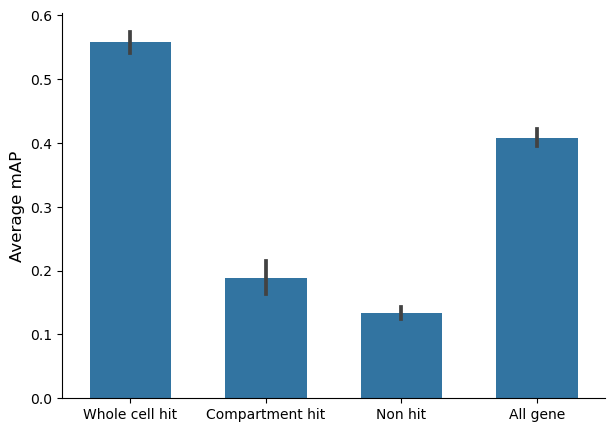

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
errorbar='se'
ax = sns.barplot(data=df_results,
                  x='group', 
                  y='mAP', 
                  errorbar=errorbar,
                  color='tab:blue',
                  width=0.6,
                 )


ax.set_title('',size=14)
ax.set_xlabel(None,size=12)
ax.set_ylabel('Average mAP',size=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(output_folder,'figure_panels','CP498_CP_5_FDR_mAP_values_barplot.png'),dpi = 300,bbox_inches='tight')
plt.show()